# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [3]:
# the next_state function allows to compute the next state given a current state and action
# This is going to be very helpful to run an episode!

# assume we set x = [theta, omega] = [0,0] and u = 5, we can get the next state using
x = np.array([0.,0.])
u = 5
x_next = pendulum.get_next_state(x, u)

print(f'the next state is {x_next}')

the next state is [0.02227801 0.48969119]


In [4]:
import math
pi = math.pi
def get_cost(x,u):
    cost = (x[0] - pi)*(x[0] - pi) + 0.01*x[1]*x[1] + 0.0001*u*u
    return cost

In [5]:
def get_policy_and_value_function(q_table,u):
    value_function = np.zeros((50,50))
    policy = np.zeros((50,50))
    for i in range(50):
        for j in range(50):
            value_function[i,j] = np.min(q_table[i,j])
            policytemp = np.argmin(q_table[i,j])
            if policytemp == 0:
                policy[i,j] = -u
            elif policytemp == 1:
                policy[i,j] = 0
            elif policytemp == 2:
                policy[i,j] = u
                
    return policy, value_function

# [policy, value_function] = get_policy_and_value_function(q_table)

# print(value_function)

In [6]:
# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# print(discretized_theta)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)
# print(discretized_omega)

# now given an arbitrary continuous state theta
theta_arbitrary = 0.6234
omega_arbitrary = 1.234

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))
index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))

# and find the closed discretized state
closest_theta_state = discretized_theta[index_in_discretized_theta]
closest_omega_state = discretized_omega[index_in_discretized_omega]

print(f'the discretized theta closest to {theta_arbitrary} is {closest_theta_state} with index {index_in_discretized_theta}')
print(f'the discretized omega closest to {omega_arbitrary} is {closest_omega_state} with index {index_in_discretized_omega}')

def index_of_theta_and_omega(current_state):
    theta_index = np.argmin(np.abs(discretized_theta - current_state[0]))
    omega_index = np.argmin(np.abs(discretized_omega - current_state[1]))
    return theta_index,omega_index

# [a, b] = index_of_theta_and_omega(1.4,0)
# print(a)


the discretized theta closest to 0.6234 is 0.6283185307179586 with index 5
the discretized omega closest to 1.234 is 1.3469387755102042 with index 30


In [7]:
def particular_policy_and_value_function(q_table,state,u):
    [val2, val3] = index_of_theta_and_omega(state)
    q_value = np.min(q_table[val2,val3])
    policytemp = np.argmin(q_table[val2,val3])
    if policytemp == 0:
        policy = -u
    elif policytemp == 1:
        policy = 0
    elif policytemp == 2:
        policy = u    
    return q_value, policy

In [8]:
gama = 0.1
epsilon = 0.1
x0 = np.array([0.,0.])
x_start = x0
x_des = np.array([np.pi,0])
alpha = 0.99
u = 4
q_table = np.zeros((50,50,3))
episodes = 15000
cost = np.zeros(episodes)


def q_learning(q_table):
    for t in range(episodes):
        x_start = np.array([0.,0.])
        for i in range(100):        
            val1 = (np.random.choice([-u,0,u],1)).item()
            [qval, pol] = particular_policy_and_value_function(q_table,x_start,u)
            choices = [pol, val1]
            action = np.random.choice(choices,1,(1-epsilon,epsilon))
            if action == -u:
                idact = 0
            elif action == 0:
                idact = 1
            elif action == u:
                idact = 2    
            x_next = pendulum.get_next_state(x_start,action)
            cost[t] += (alpha**i)*get_cost(x_start,action)
            # [a,b] = index_of_theta_and_omega(x_next)
            delt = get_cost(x_start,action) + alpha*np.min(q_table[index_of_theta_and_omega(x_next)]) - np.min(q_table[index_of_theta_and_omega(x_start)])
            [a,b] = index_of_theta_and_omega(x_start)
            q_table[a,b,idact] = q_table[a,b,idact] + gama*delt
            x_start = x_next
            
    return(q_table)
    
q_table = q_learning(q_table)    
    
    
    

In [9]:
def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    [a,b] = index_of_theta_and_omega(x)
    actiontemp = np.argmin(q_table[a,b])
    if actiontemp == 0:
        action = -u
    elif actiontemp == 1:
        action = 0
    elif actiontemp == 2:
        action = u    
    return action


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

<IPython.core.display.Javascript object>


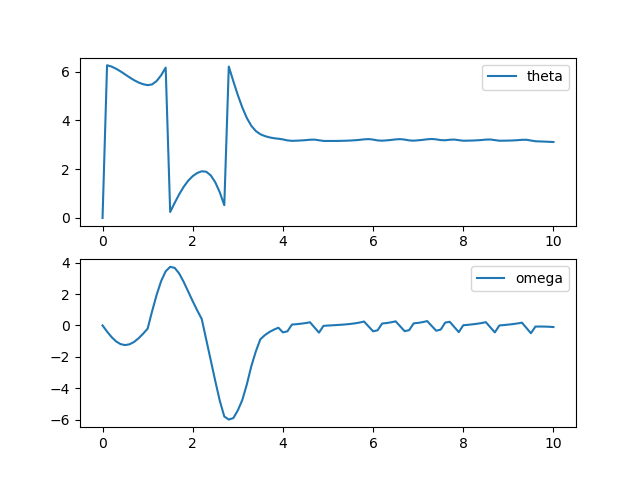

<IPython.core.display.Javascript object>


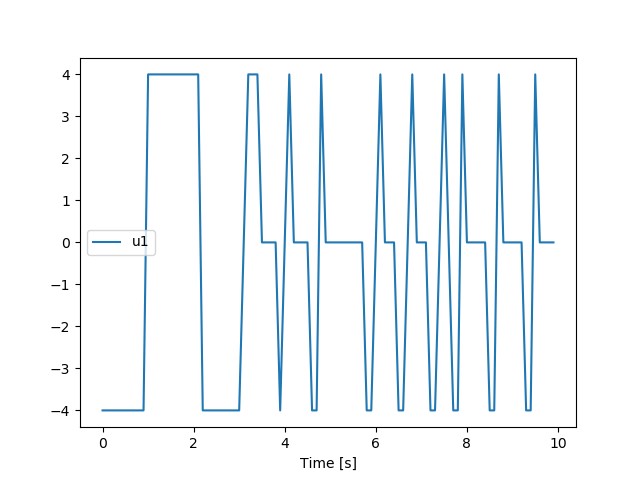

Text(0.5, 0, 'Time [s]')

In [10]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [11]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACIk21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANImWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320iVM7NEnmHG6sJrpM/dh0nQ+5r39OQ6cHUFm0hB1kTY014bpkFYpfap7yuKrbFL3C
DF86Ek0m3piGtcybvONVtvleOBuQdzGdAa5YB52LAliqLd+bi6McnSKY2FoPfu5QadXS6EUfB0ep
YweeSRli/l0MDbC7pvc5D0pHCflfzYJd0GvBN+Tc9+CZCLt+T1EAFzZj+Wv7CTv80YchbrFtasJC
NYjeQyCadl0KgGz2/JEsFOkJUiPtq/wKfkNJeUSf9J37c2sBNTkM1gkUi/3xkDveK6vW5WnScaxf
EEWUnUfb7hzm/SxzoncYdAn5BZ9cwwymesZ+pg7wAFloui2wUH8seRsXC6KnsX7IVImY4+Oe/ano
SwLNniS2MzxbV1doQbay5LT+qzONsVBjTb4AivZVqlBz7UEVaqtzWm7XuiF9PPBefZ8oALnbWecA
AAMBLDBRyppjkCS+nOqJhuBcy6xUTlQjfGN0lmX1gZ4VQuWcWCnVM7lLYuK/XiiWJIeYSAF/K+Al
QZj6+JcX7eyUxRQ2+M3jcNu+XI9+1Cai1PASc0viqTtA9ZndKYQpAhlJqGaymTVqCl3jB8VykVBD
2Cxu3DB7FHgaxH78I3+kyAT5qOV/ybPTVIqeiUFtxODUHGAMk4WxKuUWq3/OaDlW9fWV84dq2Gi+
jLt13+9hSqMu+W9g1BYVtdWrC9IHXzsPXHev/y81KCsG+3564aevIvqDyI8tb2VUcQJKeetHuhit
Zz2novLgo0vtnIc2n0sZ+ZBm89b/17pLaiazFXE+ZE0Cm4MZ7MZTkWhB/1PVxgtNUk3osb9jZI6u
nCX7cfEaLYWnODsMu08GQ2Td/CCYh3Sxn5kIlFkv738Qjy1ea9+jFVj8WPJOez9CS/lCr3g+DTGy
o0ExVEywR90xu/HwfJkOJtHQ7jw4Si2U/2auyKpLkDaA9SmxIgNaYdhKOJknWTWXdYOwrYXVQ7DF
tNd5bgcwh3XdE5mEhSEwwESzP9pgrDiH/9+07n+YmMtjV13+Q0jy5S8V9ApimsC/sl+5vhYJxBsk
lrIfSNLJs2U8ISUwe3bGbJKwT4Hmclbk5JRwAEe3S8JVDZL6wdcFvIUX2xw1fe2O5w337NqVSyX7
f//2IXdQK7MN+Vr7fikN70AUe5Ah47bQlvwqGYv8Lx1r23l2dL+fp+Flzt3wNb0aDT3WR2hKZZ7B
iHx+7jkIPt5m0DLQU4CW5mFcPoWs0vQzeToOz8H6pXf0PEY4xGjwHUG80Np/muAgRpehqkCardNM
7DVHmbbZQDX9QgRJ8LtrOwJAc5E7tRlxI0Hhpm3Vw4Y4vVg7SE5OuWXCVhF5ixsIYqImTo7Pt5Gh
XYNlHHPH0aP1SLMwLSiex7xxBj2RWv0mXLzXxSEVJe/jgQVYSt2ELs/ZQEsfFVB50l/yeDliPyiD
Dr4keAk0hxyRw8XQHxHxAkmrV9mdSEH49VbXBr6fz5Hb/5MfGoCjwtIpgEcyDDGfAHM3u4OyuS0l
30UOpU1OZbYFQGMDkXimR+cvJ1rb+2TH0Jilt+mSg/x6pBzP+yPdbZuxvFlxiSpHTAZj5lAY68ZJ
z2l3jHLQgKJ55CifdPtptQV3qtRpM1vq3wNLj8SAixCZTw58HKxIYQthZFweWyBaH0xgXl0RGAxB
dt7FsDX6ma0IvW44Uw1IsSjHf61VxVrp6U4zWJBeYXtwsVUiFtt8kNZ360dS0OIGaeORcKEtF221
C8o/+3s8NF/v7NkjWTmoHX/+YEGdNSxSOHQZ5xkQP03nMXqH1/a48ufLbWBeBL2ZumTV2MRcX4sq
rbRHCCL1sJNjcCO29qdbNqJnGpKJKgff8o5JdfB1DBOAdRbrqYyCrLQmusu+YbQ3goTeTdrEoTxE
GI6ZZ/K/EJ5AC5LYDM5edZltD/9rNyOqr/4+d6n7edoIqepf5/rqZM7bHalkuPEByMBMcqrNMV13
RgX6dsH8SOO3/67F5CrOLMVGGA6JO8uvF6LqBwbXit+J9K+zOEcyPFvr4SXScsUCDFw9RJaQsQhb
tVAjbQqF/o83FnikDt0PhZVftmVBZe8E3lfqMm+Thss6q/ZAAAu48VJh7VRJOragU5srf9BPbR29
lMQs0rhIhi6iq928aaP1mIiej31zPxlFPp/J6ZBSbe3Rwrz7zDLYl6GfVuh6PTGIhNJbBOg0wtGy
LadLmNXSgpZ3mHDuPD6zrKi3XIlwc6HgIkvrV3wN+wn94zzoub7e0m1BTB4zZJeRQGSY4nWxy/Hn
wx3Hgx1UtGuTqDVjv2x/cqe1rSO4BXLkPhz8CuPhS5uY+hv3tjR7D0HyTzFx8rOPHQwUE+11w2vQ
myfm5rY81JsTtDMcqPfR7kpbz6rAbM6e2kfDIAQqWTn2MdTsDfOUFJg+0q7tqK6dynrElhSxFBnF
9yS4j7Hvyhfoa8fNSWo7y91TtpRpv1dKCc9TFjoKpkvp2x43AT9tv+yHc3XERzYC+Pe/DpjDcILT
sM+HpNJePoDwzK6yWGcEDBLktKT1OQzGs5Tb/x15NWej7VD0vRH5ljNX4vfQOIyWaHZmtbyG8dmd
daOC0LF3CmmhNhAMPaT1v

<IPython.core.display.Javascript object>


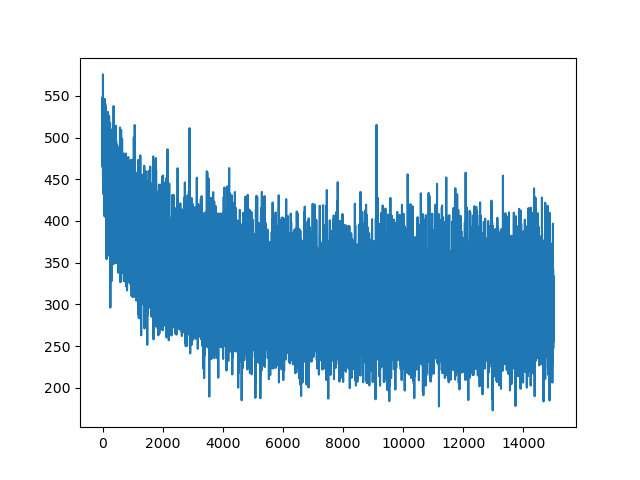

In [12]:
plt.figure()
plt.plot(cost)
plt.show()

<IPython.core.display.Javascript object>


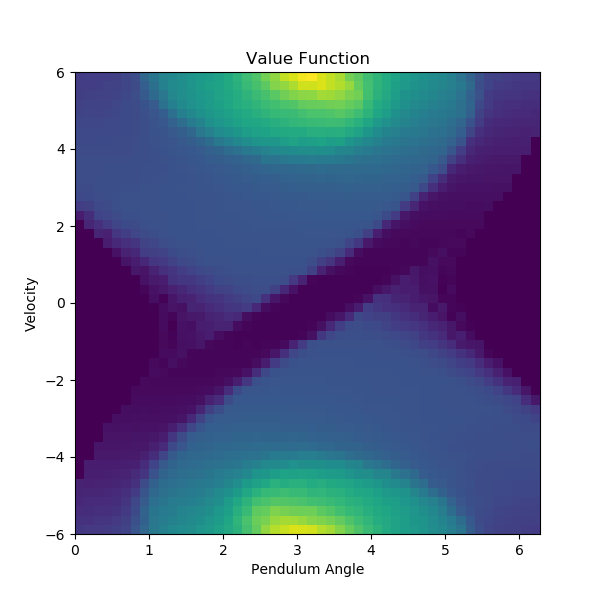

<IPython.core.display.Javascript object>


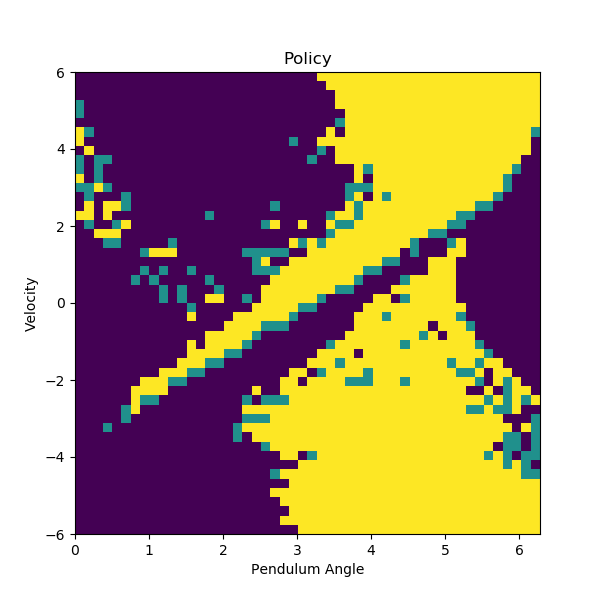

Text(0.5, 1.0, 'Policy')

In [13]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2
u = 4
[policy, value_function] = get_policy_and_value_function(q_table,u)
# value_function = np.zeros([50,50])
# policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

In [14]:
# When u = 5

gama = 0.1
epsilon = 0.1
x0 = np.array([0.,0.])
x_start = x0
x_des = np.array([np.pi,0])
alpha = 0.99
u = 5
q_table = np.zeros((50,50,3))
episodes = 10000
cost = np.zeros(episodes)


def q_learning(q_table):
    for t in range(episodes):
        x_start = np.array([0.,0.])
        for i in range(100):        
            val1 = (np.random.choice([-u,0,u],1)).item()
            [qval, pol] = particular_policy_and_value_function(q_table,x_start,u)
            choices = [pol, val1]
            action = np.random.choice(choices,1,(1-epsilon,epsilon))
            if action == -u:
                idact = 0
            elif action == 0:
                idact = 1
            elif action == u:
                idact = 2    
            x_next = pendulum.get_next_state(x_start,action)
            cost[t] += (alpha**i)*get_cost(x_start,action)
            # [a,b] = index_of_theta_and_omega(x_next)
            delt = get_cost(x_start,action) + alpha*np.min(q_table[index_of_theta_and_omega(x_next)]) - np.min(q_table[index_of_theta_and_omega(x_start)])
            [a,b] = index_of_theta_and_omega(x_start)
            q_table[a,b,idact] = q_table[a,b,idact] + gama*delt
            x_start = x_next
            
    return(q_table)
    
q_table = q_learning(q_table) 
    
    

In [15]:
def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    [a,b] = index_of_theta_and_omega(x)
    actiontemp = np.argmin(q_table[a,b])
    if actiontemp == 0:
        action = -u
    elif actiontemp == 1:
        action = 0
    elif actiontemp == 2:
        action = u    
    return action


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

<IPython.core.display.Javascript object>


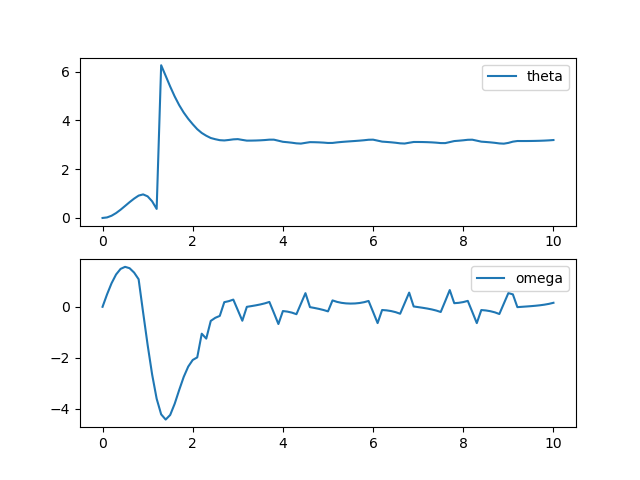

<IPython.core.display.Javascript object>


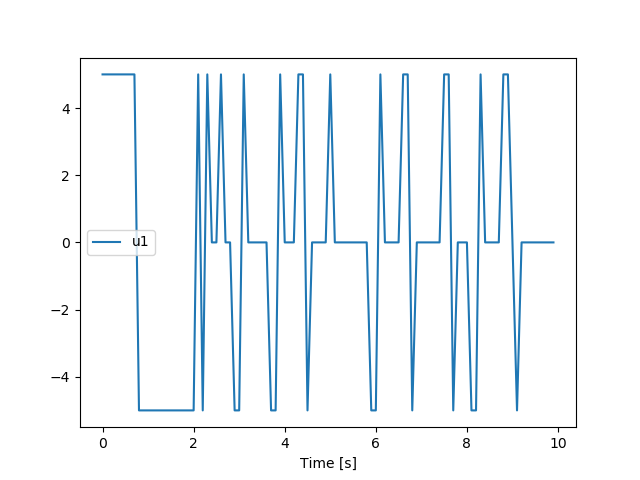

Text(0.5, 0, 'Time [s]')

In [16]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [17]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB9rW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANEGWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320iVM7NEnmHG6sJrpM/dh0nQ+5r39OQ6cHUFm0hB1kTY014bpkFYpfap7yuKrbFL3C
DF86Ek0m3piGtcybvONVtvleOBuQdzGdAa5YB52LAliqLd+bi6McnSKY2FoPfu5QadXS6EUfB0ep
YweeSRli/l0MDbC7pvc5D0pHCflfzYJd0GvBN+Tc9+CZCLt+T1EAFzZj+Wv7CTv80YchbrFtasJC
NYjeQyCadl0KgGz2/JEsFOkJUiPtq/wKfkNJeUSf9J37c2sBNTkM1gkUi/3xkDveK6vW5WnScaxf
EEWUnUfb7hzm/SxzoncYdAn5BZ9cwwymesZ+pg7wAFloui2wUH8seRsXC6KnsX7IVImY4+Oe/ano
SwLNniS2MzxbV1doQbay5LT+qzONsVBjTb4AnlyOOzoI0ndZaJbDxfTICnYg73Zg/CF0/OuhK2I4
GqSClWmjkZOhDjAfSv0VWdyYMlaLy4TAO5qmTUJSPLJmLs221SDWn8af+MWZZk6zgaaPe61h7BBq
AK1y7hGXp7EAIiz2BX+yQ6iRCXuR+EC93besc3r79jr5kkKPGZHlFz+KpO0D1md0pfV8pCrTUM1l
MmrS/KPOXopF4UCm3oBlzwqp6mmJeWokahuc09Kkh8r/k1umqRVCcVPWJ4l1IpUPt26RwlvFvTuA
fuRg2LZZZQvVGkZP6z3XqAYnApHQgxQEUbz/W9mJ6pkk/johxZ//7/aG7Pkf2JD64SbUbxIkPeN9
0ro6ZXQzbR+HgCSEHkolix7IiFSCmYp53GL50WxBwDf/602yxqXt9DOYW29rGxZ+92NuC/BlcMNo
vzNfOtBEv9UfzcUZQVChL9uPiNFWL8LudgqtmZIbHSBBZyC2UDRbE0FVd/ewlZkY5PWY5Ugk83n+
PvgAA3/GmsKCxHlqQ+qOFWzUw6mwkyvf73rjkPY8+GoUZIYRQkaULAUYOTk7p5mFWuv3t5RxMk6y
ay7rB2FbC6qHeIjNEMzhuul0liRgMwrlITDARLM/wlERFqHzafwwds3XdmzhGo5DSPLlLxX0CmDp
Ofv057zHoUQsbmZKAKxHAzIkJ12mwUi2lchKfqGGgPM5K3JySjgAIBml4SqGyX1g64LeIa/yyg1f
e2PTvPKgFwMAhvVmhgqDUkXAPHWXuYknb8gbI7Nk7Swqtl+OKOGgRf4SCjZMrmHq988QPROIAALF
9URBXhNxHk4hcMDI1Yb4JeLItPZ4Wck9e0gcUAJfh4bMLue+Kr59peg4fWaPduZ3EAAD/Rm/y3a1
ygNgBttAm/VfHvmuZ3VJyBVX2RmP3t1Hmh2Br2CEtZQOflkZwXaHJfxgHQqHi4Q05udGaXQf5Urm
6OUiLVg2UctgkQoehFVZq64NVe8cQY9+QGo2Pr1EU4srv1bvxqhuTM51gqfSDsSOKMbNddSMkM8z
yh52ygQab0RUs6rUXvv+hfo9JQ+xt8gcHsfIy9BFKM10ZbQwyO7wa57JCXaQL/SaPmFCHE+NdN87
C19f++ave2/pMi7oVc1G7zeide36KmVHj8gZnrWoeCM9dhSj/ub3W2bhSCE7b3XfEtZklIDGhKp1
wvuUjTyl8tEFK1fp90+2m1BXeqkUrVzRk6uE/td51AoTW0Yvg5WJDCFsLgY/juQLQ+mMC8vIQzhS
tf5/Nga/UzWhF63HCmGqyPsS34E4Ns13oNJ45rDDuAU94OP1mWdMrePbaM0U8i3E2vQCveSZUQZe
mYpdk8yfMtvbKVvik1ZQE/H804ZDSmdF7ZJ5aksuDH6ABC9Q+v7XHlzx8xAQQgKWky7kH5e74UNS
qtoJhGS/Owk2Nv9GWskyrdJlONSUSVDRv5RyS6+DqGDhlXwy9GcQo84s7f+SR9koXPrJgLAguMFl
WDKz4wFCTbyD2JWa9+uaBk6kl/9HCZ7h//0lf0yOd1RYp6mhr/apAe6t/3+g0sZPPpvuprPyTZmY
lSTf76XwZx6ikY8ElJlcUixfmKkW2YjEr7rIsboCwwGZ2srNGW2gxMFsRSoXRUAHljAqg/i5cnz0
Ov5cLyWyaw6nrrbQgfQGi/FFTm7pC8vST9JFjVlYlBXoAAVgprS9tkEx4NmN1ZUohWdbzYSsq/Lq
5rR44GsZtxmJz2TknrwtElSyeP+si9iX5Rxjc/0ni/jfemiN9DlAgUM7sHrJu1hnaFXe2QMyYByx
HjCozZifAb9hQx/M94xCNWFla8PABKCTHO+pv4pTAjUe5Hnwx3Hgx1UtGudvIMB4Fx/cqe5TFPvU
8VehpL2LRu0old55IXo/0S4Iin0K4CbuW7euBYPgYILty9CYseybimbWTOt3asZUe+j3vEIKbH8m
yyR4Eitn7wLgWCweXNM9DW4XPm3e5KvnQ3tgXHnuSECCUG/UxrzNjmIeI29R1zpvPpsM0FKx2dw8
YdiuU2Eq6yjM29V1LHeGQmET/1hLT4zmI7Hr1QY0pcuHg5L+izs/mCZ9UfOE5Q6mgyLbgwNtsHtl
8iwfe/+c+8o+q597YwnLf74mmQKswdI8NcSY4n9lSxKlVi3Dvcyt10QYO8BxLn/HNVlfINORM8B2
5BEbgtDy8ELFcLbCWr101

<IPython.core.display.Javascript object>


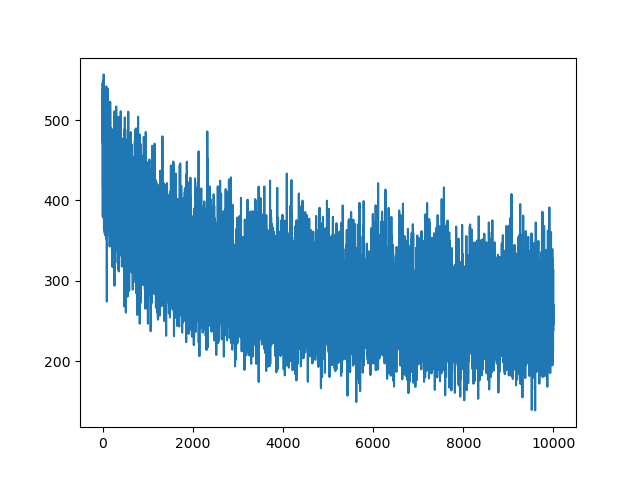

In [18]:
plt.figure()
plt.plot(cost)
plt.show()

<IPython.core.display.Javascript object>


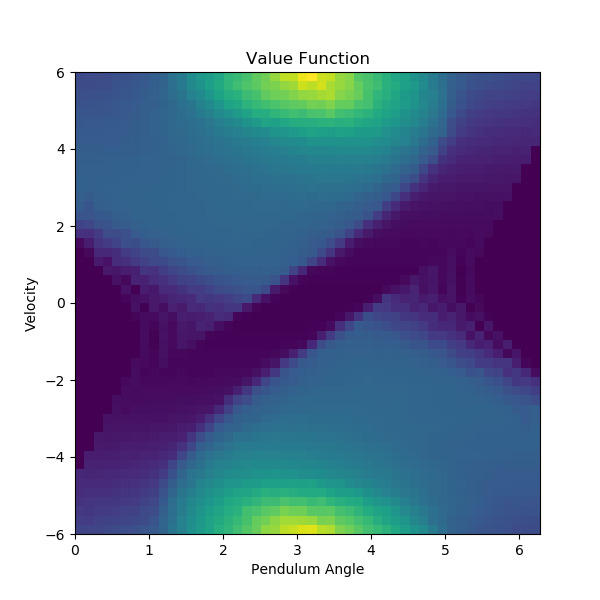

<IPython.core.display.Javascript object>


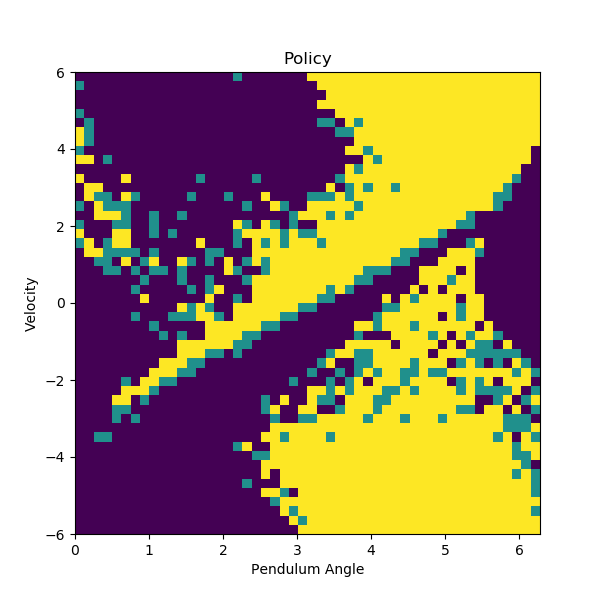

Text(0.5, 1.0, 'Policy')

In [19]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2
value_function = np.zeros([50,50])
policy = np.zeros([50,50])
u = 5

[policy, value_function] = get_policy_and_value_function(q_table, u)
# value_function = np.zeros([50,50])
# policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')